Files already downloaded and verified
Files already downloaded and verified
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Epoch: 0, Loss: 1.578476071357727, Accuracy: 46.44%
Epoch: 1, Loss: 1.2649692296981812, Accuracy: 58.77%
Epoch: 2, Loss: 1.2749085426330566, Accuracy: 61.66%
Epoch: 3, Loss: 0.9361148476600647, Accuracy: 65.75%
Epoch: 4, Loss: 0.4191710650920868, Accuracy: 67.67%
Epoch: 5, Loss: 0.47089260816574097, Accuracy: 69.37%
Epoch: 6, Loss: 0.9023897647857666, Accuracy: 70.49%
Epoc

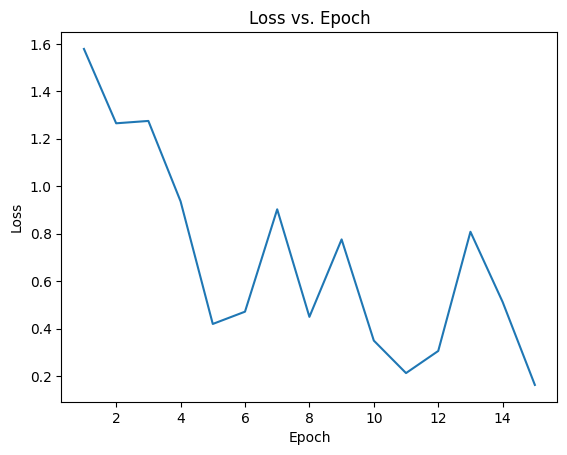

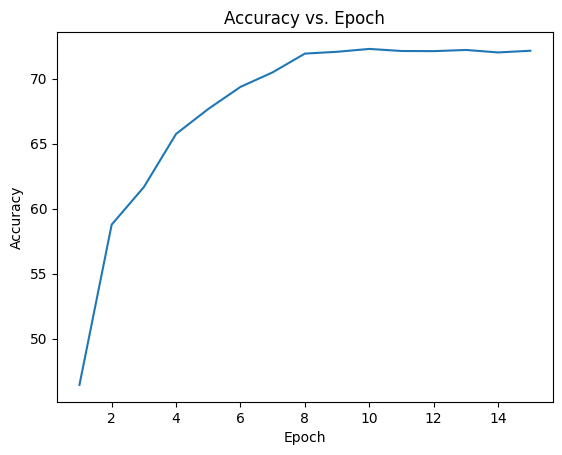

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load the CIFAR-10 dataset
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
       
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Initialize the model and move it to the GPU
model = CNN()
print(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Lists to store the epochs, losses, and accuracies
epochs = []
losses = []
accuracies = []

# Train the model
for epoch in range(15):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # <-- Modify this line

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
    scheduler.step()
    # Calculate the accuracy on the test dataset
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100. * correct / total

    print(f"Epoch: {epoch}, Loss: {loss.item()}, Accuracy: {accuracy}%")
    # Append the epoch, loss, and accuracy to the lists
    epochs.append(epoch+1)
    losses.append(loss.item())
    accuracies.append(accuracy)

print('Finished Training')
# Test the model on the testing data
model.eval()  # switch to eval mode
with torch.no_grad():  # do not calculate gradients
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # move to device
        outputs = model(images)  # feed through model
        _, predicted = torch.max(outputs.data, 1)  # get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  # compare predictions to ground truth
    print('Accuracy of the model on the test data: %d %%' % (100 * correct / total))

# Plot the loss over the epochs
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.show()

# Plot the accuracy over the epochs
plt.plot(epochs, accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.show()
